In [3]:
# Import necessary libraries
import pandas as pd
import nltk
import json

# Download ALL necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab') # <-- This is the new line we added
nltk.download('stopwords')
nltk.download('vader_lexicon')

# --- ROBUST DATA LOADING ---
data = []
with open('News_Category_Dataset_v3.json', 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            pass

df = pd.DataFrame(data)

print("Successfully loaded the data! Here are the first 5 rows:")
print(df.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Successfully loaded the data! Here are the first 5 rows:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when h

In [4]:
# Initialize the stemmer and get the set of English stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Tokenize the text (split into words) and convert to lowercase
    tokens = nltk.word_tokenize(text.lower())

    # 2. Remove stopwords and stem the remaining words
    # We also keep only alphabetic words to remove punctuation and numbers
    filtered_tokens = [stemmer.stem(w) for w in tokens if w.isalpha() and w not in stop_words]

    # 3. Join the tokens back into a single string
    return " ".join(filtered_tokens)

# Apply the function to your 'headline' column to create a new 'processed_headline' column
# This is the most intensive step and might take a minute or two to run on all 200,000+ headlines.
print("Starting text preprocessing... (This may take a moment)")
df['processed_headline'] = df['headline'].apply(preprocess_text)
print("Text preprocessing complete.")

# Display the original vs. the new processed headline for the first 5 rows to see the difference
print("\nHere's a comparison of the original vs. processed headlines:")
print(df[['headline', 'processed_headline']].head())

Starting text preprocessing... (This may take a moment)
Text preprocessing complete.

Here's a comparison of the original vs. processed headlines:
                                            headline  \
0  Over 4 Million Americans Roll Up Sleeves For O...   
1  American Airlines Flyer Charged, Banned For Li...   
2  23 Of The Funniest Tweets About Cats And Dogs ...   
3  The Funniest Tweets From Parents This Week (Se...   
4  Woman Who Called Cops On Black Bird-Watcher Lo...   

                                  processed_headline  
0          million american roll sleev covid booster  
1  american airlin flyer charg ban life punch fli...  
2                        funniest tweet cat dog week  
3                         funniest tweet parent week  
4                  woman call cop black lose lawsuit  


In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

# Function to get the sentiment category from the compound score
def get_sentiment(text):
    # Get the polarity scores dictionary
    scores = sid.polarity_scores(text)
    # Decide sentiment based on the compound score
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the original 'headline' column for the most accurate sentiment
print("Starting sentiment analysis...")
df['sentiment'] = df['headline'].apply(get_sentiment)
print("Sentiment analysis complete.")

# Display the first 5 rows with the new 'sentiment' column
print("\nHere are the headlines with their calculated sentiment:")
print(df[['headline', 'sentiment']].head())

Starting sentiment analysis...
Sentiment analysis complete.

Here are the headlines with their calculated sentiment:
                                            headline sentiment
0  Over 4 Million Americans Roll Up Sleeves For O...   Neutral
1  American Airlines Flyer Charged, Banned For Li...  Negative
2  23 Of The Funniest Tweets About Cats And Dogs ...  Positive
3  The Funniest Tweets From Parents This Week (Se...  Positive
4  Woman Who Called Cops On Black Bird-Watcher Lo...  Negative


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# --- Topic Modeling ---

# 1. Vectorize the text. This converts our text into a matrix of word counts.
# max_df=0.9 means "ignore words that appear in more than 90% of documents" (too common)
# min_df=2 means "ignore words that appear in less than 2 documents" (too rare)
print("Vectorizing text for topic modeling...")
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['processed_headline'].dropna()) # dropna() handles any empty headlines

# 2. Apply the LDA model. We are asking it to find 10 topics.
print("Applying Latent Dirichlet Allocation (LDA) model...")
LDA = LatentDirichletAllocation(n_components=10, random_state=42)
LDA.fit(doc_term_matrix)

# 3. Display the topics and their top words.
print("\nTopic modeling complete. Here are the top 10 words for each topic:")
for i, topic in enumerate(LDA.components_):
    # Get the top 10 words for the current topic
    top_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"\n--- Topic #{i} ---")
    print(top_words)

Vectorizing text for topic modeling...
Applying Latent Dirichlet Allocation (LDA) model...

Topic modeling complete. Here are the top 10 words for each topic:

--- Topic #0 ---
['west', 'korea', 'jimmi', 'sex', 'media', 'south', 'social', 'north', 'season', 'game']

--- Topic #1 ---
['make', 'way', 'good', 'love', 'kid', 'divorc', 'photo', 'wed', 'food', 'day']

--- Topic #2 ---
['work', 'american', 'help', 'men', 'marriag', 'chang', 'year', 'health', 'way', 'women']

--- Topic #3 ---
['court', 'school', 'parent', 'want', 'kid', 'state', 'thing', 'know', 'say', 'america']

--- Topic #4 ---
['cancer', 'peopl', 'new', 'art', 'holiday', 'black', 'stori', 'watch', 'week', 'video']

--- Topic #5 ---
['obama', 'democrat', 'republican', 'hillari', 'hous', 'gop', 'clinton', 'say', 'donald', 'trump']

--- Topic #6 ---
['citi', 'lesson', 'york', 'recip', 'life', 'make', 'babi', 'best', 'photo', 'new']

--- Topic #7 ---
['super', 'travel', 'video', 'fashion', 'star', 'home', 'dress', 'style', 'lo

Generating Sentiment Pie Chart...


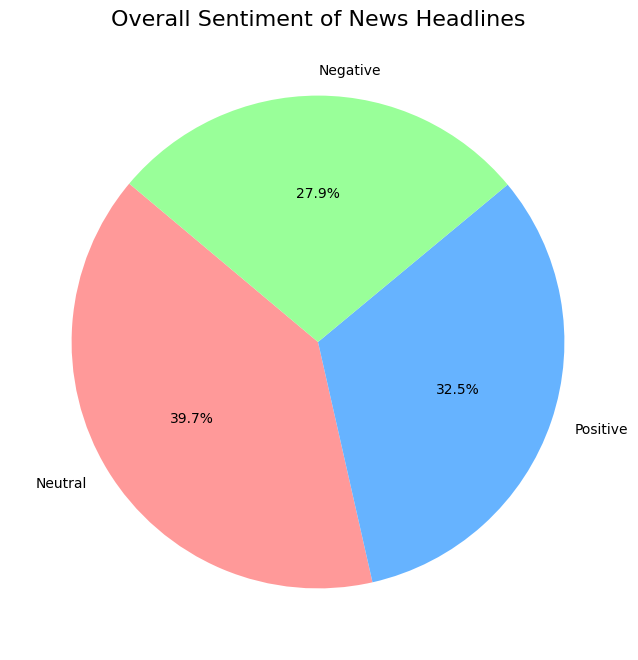


Generating Word Cloud...


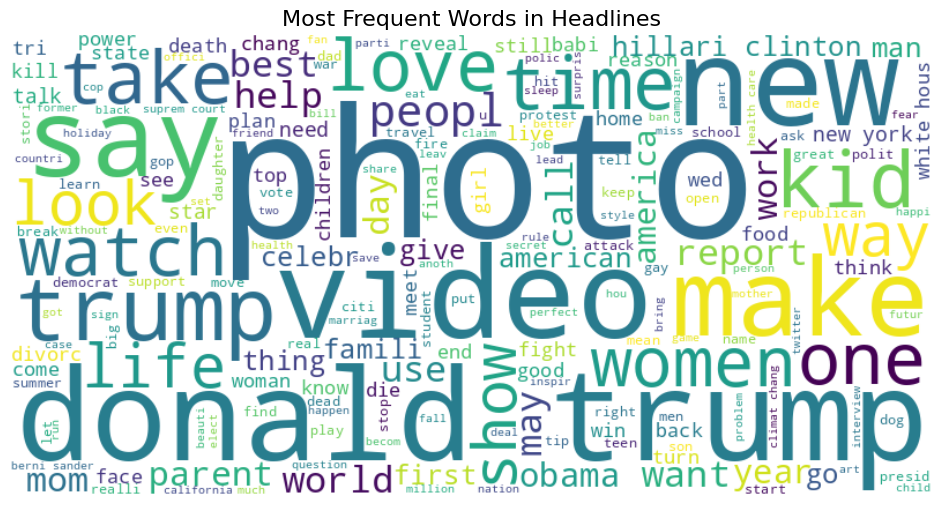

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# --- Visualization 1: Sentiment Pie Chart ---
print("Generating Sentiment Pie Chart...")
plt.figure(figsize=(8, 8))
# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()
# Create the pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Overall Sentiment of News Headlines', fontsize=16)
plt.ylabel('') # Hides the 'sentiment' label on the side
plt.show()


# --- Visualization 2: Word Cloud ---
print("\nGenerating Word Cloud...")
# Join all the processed headlines into one big string of text
all_words = ' '.join([text for text in df['processed_headline'].dropna()])

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_words)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Hide the axes
plt.title('Most Frequent Words in Headlines', fontsize=16)
plt.show()